In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import convolve1d
import scipy
import matplotlib.patches as patches


from cca.data_util import moving_center, load_sabes_data, calc_autocorr_fns
from cca.cov_util import calc_cross_cov_mats_from_data, calc_pi_from_cross_cov_mats
from cca import ComplexityComponentsAnalysis
from cca.cca import DynamicalComponentsAnalysisFFT

In [2]:
NEURAL_DIR = "/home/davidclark/Projects/ComplexityComponentsAnalysis/data/sabes/"
#NEURAL_DIR = "/Users/davidclark/Projects/ComplexityComponentsAnalysis/data/sabes/"
SESSION = "indy_20160627_01.mat" 
NEURAL_FILENAME = NEURAL_DIR + SESSION
BIN_WIDTH_S = .100
MIN_SPIKE_COUNT = 5000
MOVING_WINDOW = 600 #1 min

def load_neural_data():
    results = load_sabes_data(NEURAL_FILENAME, bin_width_s=BIN_WIDTH_S)
    spikes = results["M1"]
    spikes = spikes[:, spikes.sum(axis=0) > MIN_SPIKE_COUNT]
    sqrt_spikes = np.sqrt(spikes)
    sqrt_spikes_ctd = moving_center(sqrt_spikes, n=MOVING_WINDOW)
    cursor = results["cursor"]
    return sqrt_spikes_ctd, cursor

In [3]:
def dca_deflation(cross_cov_mats, n_proj, n_init=1):
    N = cross_cov_mats.shape[1]
    P = np.eye(N) #orthogonal projection matrix onto residual subspace
    V = None  #orthonormal basis of DCA projections
    opt = ComplexityComponentsAnalysis(init="random")
    for i in range(n_proj):
        cross_cov_mats_proj = np.array([P.dot(C).dot(P.T) for C in cross_cov_mats])
        if i > 0:
            #add isotropic white noise to subtracted-out subspace
            cross_cov_mats_proj[0] += 1e2 * np.dot(V, V.T)
        opt.cross_covs = cross_cov_mats_proj
        opt.fit_projection(d=1, n_init=n_init)
        u = opt.coef_
        if i == 0:
            V = u
        else:
            u_proj = np.dot(P, u)
            u_proj /= np.sqrt(np.sum(u_proj**2))
            V = np.concatenate((V, u_proj), axis=1)
        P = np.eye(N) - np.dot(V, V.T)
    return V

def dca_fft_deflation(X, T_pi, n_proj, n_init=1):
    N = X.shape[1]
    P = np.eye(N) #orthogonal projection matrix onto residual subspace
    V = None  #orthonormal basis of DCA projections
    opt = DynamicalComponentsAnalysisFFT(init="random", verbose=False)
    opt.T = 2*T_pi
    for i in range(n_proj):
        X_proj = np.dot(X, P)
        if i > 0:
            #add isotropic white noise to subtracted-out subspace
            noise = np.random.normal(0, 1e2, (len(X), i))
            embedded_noise = np.dot(noise, V.T)
            X_proj += embedded_noise
        opt.fit(X_proj, d=1, n_init=n_init)
        u = opt.coef_
        if i == 0:
            V = u
        else:
            u_proj = np.dot(P, u)
            u_proj /= np.sqrt(np.sum(u_proj**2))
            V = np.concatenate((V, u_proj), axis=1)
        P = np.eye(N) - np.dot(V, V.T)
    return V

def dca_full(cross_cov_mats, n_proj, n_init=1):
    opt = ComplexityComponentsAnalysis(init="random")
    opt.cross_covs = cross_cov_mats
    V_all = []
    for i in range(n_proj):
        opt.fit_projection(d=i+1, n_init=n_init)
        V = opt.coef_
        V_all.append(V)
    return V_all

def calc_pi_vs_dim(cross_cov_mats, V=None, V_all=None):
    if V_all is None:
        V_all = [V[:, :i+1] for i in range(V.shape[1])]
    pi_vals = np.zeros(len(V_all))
    for i in range(len(V_all)):
        pi_vals[i] = calc_pi_from_cross_cov_mats(cross_cov_mats, proj=V_all[i])
    return pi_vals

In [4]:
T_pi = 10
X, Y = load_neural_data()
cross_cov_mats = calc_cross_cov_mats_from_data(X, T=2*T_pi)

In [5]:
n_proj = 5
n_init = 5

V_deflate = dca_deflation(cross_cov_mats, n_proj=n_proj, n_init=n_init)
print("Done")

V_deflate_fft = dca_fft_deflation(X, T_pi=T_pi, n_proj=n_proj, n_init=n_init)
print("Done")

#V_all = dca_full(cross_cov_mats, n_proj=n_proj, n_init=n_init)
#print("Done")


Done
Done


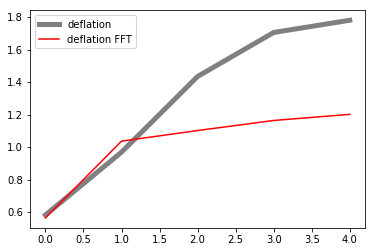

In [6]:
pi_deflate = calc_pi_vs_dim(cross_cov_mats, V=V_deflate)
pi_deflate_fft = calc_pi_vs_dim(cross_cov_mats, V=V_deflate_fft)
#pi_regular = calc_pi_vs_dim(cross_cov_mats, V_all=V_all)

plt.plot(pi_deflate, label="deflation", linewidth=5, c="gray")
plt.plot(pi_deflate_fft, label="deflation FFT", c="red")
#plt.plot(pi_regular, label="regular")
plt.legend()

In [169]:
def calc_pi_vs_dim(cross_cov_mats, V):
    pi_vals = np.zeros(V.shape[1])
    for i in range(V.shape[1]):
        calc_pi_from_cross_cov_mats(cross_cov_mats, proj=V[:i+1])
    return pi_vals
    

In [22]:
import matplotlib
matplotlib.__version__

'2.2.2'